In [111]:
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis


from RANSAC import get_inliers, get_best_dist
from ImgCropper import ImgCropper

In [112]:
image = cv2.imread('images/nb7.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(3504, 2480, 3)

In [113]:
%%time
cropped_img = ImgCropper().crop_image(image, hl_threshold=500, resize=True)

[[ 218.          202.5311831 ]
 [ 218.         2271.5311831 ]
 [1577.         2271.72513201]
 [1577.          202.72513201]]
CPU times: user 1.4 s, sys: 93.9 ms, total: 1.5 s
Wall time: 1.44 s


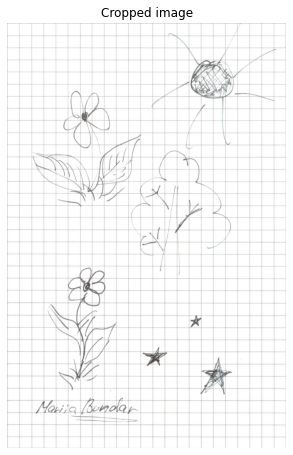

In [114]:
plt.figure(figsize=(5,10))
plt.axis("off")
plt.title("Cropped image")
plt.imshow(cropped_img)

In [115]:
# cv2.imwrite('./images/cropped.jpg', cropped_img)

find new lines and display them

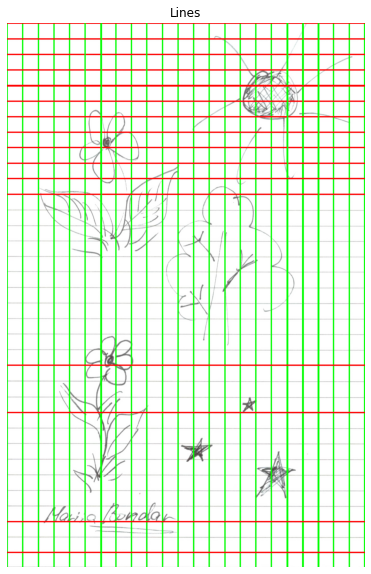

In [116]:
edges = ImgCropper.find_edges(cropped_img)
lines = cv2.HoughLines(edges, 1, np.pi/180, 600,)
img_copy = cropped_img.copy()
for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        if theta < 0.01:
            cv2.line(img_copy,(x1,y1),(x2,y2),(0,255,0),3)
        elif theta > 1.55:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),3)

plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

get approximated distance between lines

In [117]:
edges = ImgCropper.find_edges(cropped_img)
lines = cv2.HoughLines(edges, 1, np.pi/180, 600, )

rhos = lines[:, 0, 0]
thetas = lines[:, 0, 1]
vert_rhos = rhos[thetas < 0.01]
hors_rhos = rhos[thetas > 1.56]

vert_dist, start1 = get_best_dist(vert_rhos, cropped_img.shape[1])
hors_dist, start2 = get_best_dist(hors_rhos, cropped_img.shape[0])

print(f'vert_dist {vert_dist}, start {start1}')
print(f'hors_dist {hors_dist}, start2 {start2}')

vert_dist 59, start 0
hors_dist 59, start2 2


complete cells with not found lines

In [124]:
eps = 10
vert_lines = []
hors_lines =  []
for i in range(cropped_img.shape[1]//vert_dist+1):
    lines = vert_rhos[(vert_rhos > start1 + i*vert_dist - eps) & (vert_rhos < start1 + i*vert_dist + eps)]
    if len(lines):
        vert_lines.append((np.mean(lines), 0))
    else:
        vert_lines.append((start1 + i*vert_dist, 0))

for i in range(cropped_img.shape[0]//hors_dist+1):
    lines = hors_rhos[(hors_rhos > start2 + i*hors_dist - eps) & (hors_rhos < start2 + i*hors_dist + eps)]
    if len(lines):
        hors_lines.append((np.mean(lines), 1.5707))
    else:
        hors_lines.append((start2 + i*hors_dist, 1.5707))

display lines

(2069, 1359, 3)

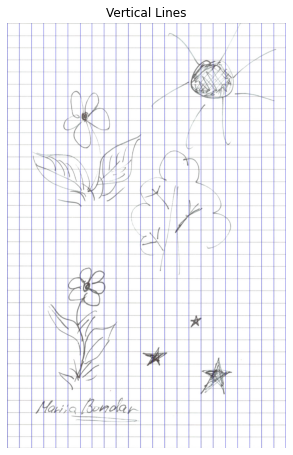

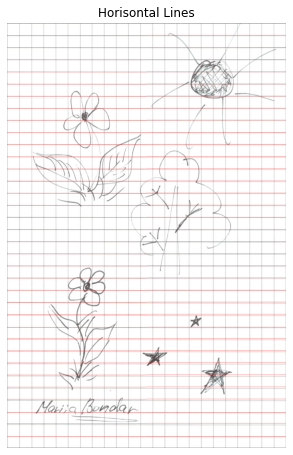

In [125]:
img_copy = cropped_img.copy()    
for rho, theta in vert_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 4000*(-b))
    y1 = int(y0 + 4000*(a))
    x2 = int(x0 - 4000*(-b))
    y2 = int(y0 - 4000*(a))
    cv2.line(img_copy,(x1,y1),(x2,y2),(0,0,255),1)
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Vertical Lines")
plt.imshow(img_copy)
cv2.imwrite('./images/cropped_vert_lines.jpg', img_copy)

img_copy = cropped_img.copy()    
for rho, theta in hors_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),1)
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Horisontal Lines")
plt.imshow(img_copy)
# cv2.imwrite('./images/cropped_hor_lines.jpg', img_copy)

# v - 23
# h - 35

img_copy.shape

resize an image to make square cells

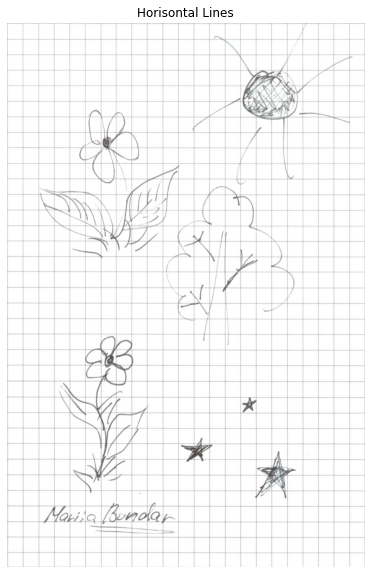

In [63]:
if vert_dist != hors_dist:
    ratio = hors_dist/vert_dist
    cropped_img = cv2.resize(cropped_img, dsize=(int(cropped_img.shape[1]*ratio), cropped_img.shape[0]), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Horisontal Lines")
plt.imshow(cropped_img)

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
>>> clustering.labels_

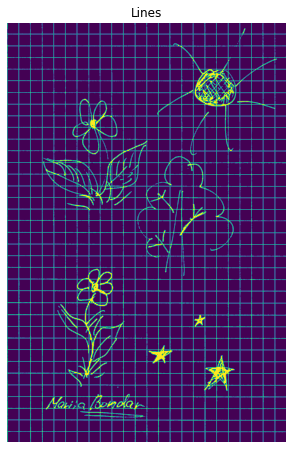

In [87]:
gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
dilated = cv2.morphologyEx(
    gray, cv2.MORPH_DILATE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
)
diff2 = 255 - cv2.subtract(cv2.medianBlur(dilated, 5), gray)
normed = cv2.normalize(diff2, None, 10, 255, cv2.NORM_MINMAX)
bw = cv2.threshold(normed, 210, 255, cv2.THRESH_BINARY_INV)[1]
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(bw)

In [88]:
skel, distance = medial_axis(bw, return_distance=True)

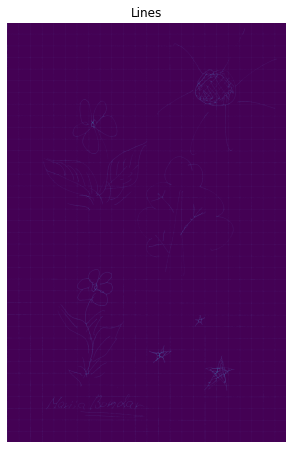

In [89]:
skeleton = distance * skel

plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(skeleton)

In [99]:
distance

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.41421356, 2.        , ..., 1.        , 1.        ,
        1.41421356],
       ...,
       [0.        , 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ]])

In [149]:
pix_color = []
for rho, _ in vert_lines:
    for i in range(skeleton.shape[0]):
        for j, pix in enumerate(skeleton[i, int(rho):int(rho)+5]):
            try:
                if pix != 0:
                    pix_color.append(cropped_img[i, int(rho)+j])
            except IndexError as e:
                continue
# for rho, _ in hors_lines:
#     for j in range(skeleton.shape[1]):
#         line_dist.append(skeleton[int(rho), j])
        
pix_color = np.array(pix_color)
pix_color
# plt.figure(figsize=(10,10))
# plt.clf()
# plt.axis("off")
# plt.title("Lines")
# plt.imshow(skeleton)

array([[207, 207, 207],
       [196, 196, 196],
       [210, 210, 210],
       ...,
       [234, 239, 233],
       [196, 196, 196],
       [215, 215, 215]], dtype=uint8)

In [156]:
print("R-  ", np.min(pix_color[:,0]), np.max(pix_color[:,0]), np.mean(pix_color[:,0]), np.median(pix_color[:,0]), np.std(pix_color[:,0]))
print("G-  ", np.min(pix_color[:,1]), np.max(pix_color[:,1]), np.mean(pix_color[:,1]), np.median(pix_color[:,1]), np.std(pix_color[:,1]))
print("B-  ", np.min(pix_color[:,2]), np.max(pix_color[:,2]), np.mean(pix_color[:,2]), np.median(pix_color[:,2]), np.std(pix_color[:,2]))

R-   113 255 205.11414279217826 199.0 22.41966457780621
G-   113 255 205.07912687585267 199.0 22.468352073411417
B-   113 255 204.94224647567077 199.0 22.494561672134644


In [104]:
for rho, _ in vert_lines:
    for i in range(skeleton.shape[0]):
        skeleton[i, int(rho)-5:int(rho)+5]=[0]
        
for rho, _ in hors_lines:
    for j in range(skeleton.shape[1]):
        skeleton[int(rho)-5:int(rho)+5, j]=[0]
        

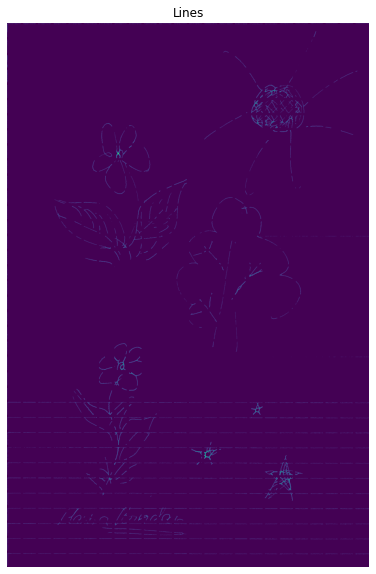

In [105]:
kernel = np.ones((2,2), dtype=np.uint8)
dist3 = cv2.dilate(skeleton, kernel)

plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(dist3)

In [106]:
for i in range(cropped_img.shape[0]):
    for j in range(cropped_img.shape[1]):
        if dist3[i,j] == 0:
            cropped_img[i,j]=[255, 255, 255]

(2126, 1415, 3)

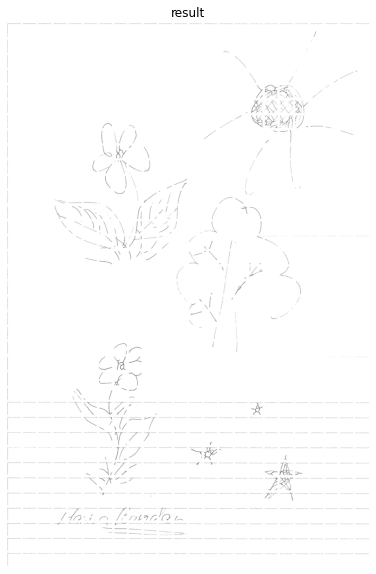

In [107]:
plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("result")
plt.imshow(cropped_img)

cropped_img.shape